In [7]:
import numpy as np
np.set_printoptions(precision=3) # only 3 decimals in print
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from tqdm import tqdm

plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 13)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

In [2]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj
from torch_geometric.nn import MessagePassing
from torch_geometric.nn.aggr import SumAggregation

In [3]:
def nice_plot_nodes(ax):
    ax.set(xticks=[], yticks=[])

def plot_graph(ax, graph, s=500):
    xmin = float(torch.min(graph.pos[:,0]))
    xmax = float(torch.max(graph.pos[:,0]))
    ymin = float(torch.min(graph.pos[:,1]))
    ymax = float(torch.max(graph.pos[:,1]))
    ax.set(xlim=(xmin-1, xmax+1), ylim=(ymin-1, ymax+1))

    # Plot the nodes:
    for idx, (pos, x) in enumerate(zip(graph.pos, graph.x)):
        text_offset = pos + s**0.5 * torch.tensor([0.02, 0.02])
        ax.scatter(*pos.T, c=f'C{int(x)}', s=s, edgecolors='black')
        ax.text(*pos.T, float(x), color='white', ha='center', va='center')
        ax.text(*text_offset.T, f'{idx}', color='black', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.2'))
    
    # Plot the edges:
    for idx, (i1,i2) in enumerate(graph.edge_index.T):
        ax.plot([graph.pos[i1,0], graph.pos[i2,0]], [graph.pos[i1,1], graph.pos[i2,1]], c='black', zorder=0)

### 5.1 Deep GNN
This exercise is about setting up networks with several convolutional GNN layers. Also a head will be added to process the node representations before aggregation. The datafiles can be downloaded from Brightspace.

In [4]:
data = np.load('dataset_for_exercise_62/nn_nnn_clusters_6.npz')
print(f'Number of graphs: {len(data["positions"])}')
print(data['positions'], data['energies'], sep='\n')

Number of graphs: 44
[[[2.963 6.123]
  [3.823 4.085]
  [6.089 4.515]
  [5.111 2.571]
  [4.956 6.065]
  [7.058 6.641]]

 [[5.644 3.297]
  [4.394 4.996]
  [5.75  6.647]
  [3.578 2.864]
  [7.066 5.071]
  [3.568 7.126]]

 [[4.871 3.129]
  [5.086 5.251]
  [3.357 6.383]
  [3.048 4.315]
  [6.753 4.344]
  [6.885 6.578]]

 [[7.389 4.353]
  [5.383 4.282]
  [6.209 6.183]
  [3.797 3.095]
  [4.226 6.849]
  [2.996 5.238]]

 [[6.637 4.567]
  [5.316 6.324]
  [4.736 3.801]
  [3.524 7.443]
  [6.357 2.492]
  [3.43  5.373]]

 [[5.285 4.808]
  [3.301 4.286]
  [3.48  6.225]
  [7.289 5.157]
  [6.332 6.855]
  [4.313 2.669]]

 [[5.61  3.169]
  [7.587 3.853]
  [5.756 5.33 ]
  [4.548 7.337]
  [2.678 6.032]
  [3.821 4.28 ]]

 [[2.836 5.842]
  [4.258 4.187]
  [6.096 4.762]
  [4.869 6.395]
  [4.931 2.241]
  [7.01  6.573]]

 [[4.822 5.602]
  [5.414 7.399]
  [6.301 4.381]
  [4.078 3.779]
  [7.036 6.215]
  [2.349 2.625]]

 [[3.442 3.802]
  [3.374 5.956]
  [5.083 7.357]
  [5.077 2.529]
  [6.299 4.094]
  [6.724 6.263]]


In [5]:
def get_graph(index, cutoff=2.5, box_size=10):

    positions = data['positions'][index]
    positions = torch.vstack([torch.tensor(p,dtype=torch.float32) for p in positions])
    D = torch.cdist(positions, positions)

    edge_index = []
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            if i == j:
                continue
            if D[i, j] < cutoff:
                edge_index.append([i, j])

    edge_index = torch.tensor(np.array(edge_index).T, dtype=torch.int64).reshape(2, -1)

    x = torch.ones((positions.shape[0], 1),dtype=torch.float32)
    y = torch.tensor(data['energies'][index],dtype=torch.float32)
    return Data(edge_index=edge_index, pos=positions, x=x, y=y)

b) Plot every 10th of the loaded graphs:

C:\Users\Jakob\AppData\Local\Temp\ipykernel_11016\337814598.py:14: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3687.)
  ax.scatter(*pos.T, c=f'C{int(x)}', s=s, edgecolors='black')


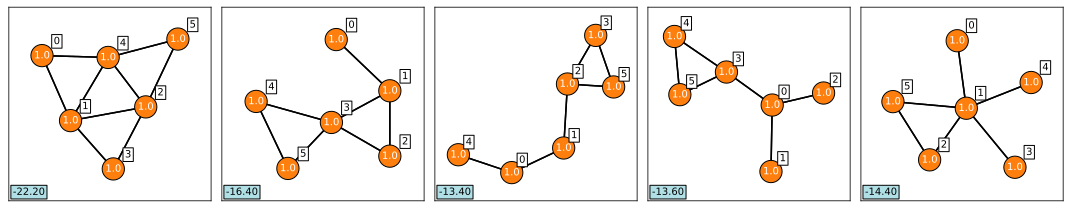

In [6]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    graph = get_graph(i*10)
    plot_graph(ax, graph)
    nice_plot_nodes(ax)
    ax.text(0.02, 0.02, f'{graph.y:.2f}', ha='left', va='bottom', bbox=dict(facecolor='powderblue', boxstyle='square,pad=0.2'), transform=ax.transAxes)
plt.tight_layout()

### 5.3 Fit with one message
c) Set up a model with a single Convolutional GNN layer with $\psi$ and $\phi$ having one neuron each. Let the model aggregate the node values to produce one number per graph. Fit the model so that it reproduces the y y-values on the graph as good as possible. Construct the parity plot:

In [29]:
class SingleLayerGNN(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.psi = nn.Linear(d_in, d_out)  # Message function
        self.phi = nn.Linear(d_in + d_out, d_out)  # Update function
        self.aggr = SumAggregation()  # Graph-level aggregation

    def forward(self, x, edge_index, batch):
        # Message passing: Aggregate messages from neighbors
        psi_of_x_j = self.propagate(edge_index, x)

        # Update node features using `phi`
        x = torch.cat([x, psi_of_x_j], dim=1)
        x = self.phi(x)

        # Aggregate node-level features to a graph-level prediction
        global_prediction = self.aggr(x, batch)

        return x, global_prediction  # Return both local and global predictions

    def propagate(self, edge_index, x):
        # Perform message passing (equivalent to `propagate` in MessagePassing)
        row, col = edge_index  # Extract edge connections
        messages = self.psi(x[col])  # Message function (applied to source nodes)
        psi_of_x_j = torch.zeros_like(x)  # Initialize message aggregation
        psi_of_x_j.index_add_(0, row, messages)  # Aggregate messages (e.g., sum aggregation)
        return psi_of_x_j


In [30]:
# Instantiate the model
d_in, d_out = 1, 1  # One feature input, one output per node
model = SingleLayerGNN(d_in, d_out)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# DataLoader for the graphs
train_loader = DataLoader([get_graph(i) for i in range(44)], batch_size=4, shuffle=True)

# Training loop
n_epochs = 2500
losses = []
for epoch in tqdm(range(n_epochs), desc="Training"):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        predictions = model(batch)  # Forward pass
        loss = loss_fn(predictions, batch.y)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        total_loss += loss.item()
    losses.append(total_loss / len(train_loader))

# Plot training loss
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(range(1, n_epochs + 1), losses)
ax.set(xlabel="Epoch", ylabel="Loss", title="Training Loss Curve")
plt.tight_layout()
plt.show()


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

Training:   0%|          | 0/2500 [00:00<?, ?it/s]


TypeError: SingleLayerGNN.forward() missing 2 required positional arguments: 'edge_index' and 'batch'

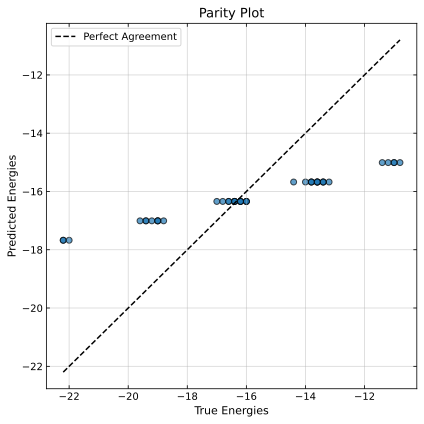

In [15]:
# Test the model on the graphs
model.eval()
predicted_energies = []
true_energies = []
for i in range(44):
    graph = get_graph(i)
    prediction = model(graph).item()
    predicted_energies.append(prediction)
    true_energies.append(graph.y.item())

# Plot parity plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(true_energies, predicted_energies, alpha=0.7, color='C0', edgecolor='k')
ax.plot([min(true_energies), max(true_energies)], [min(true_energies), max(true_energies)], 'k--', label="Perfect Agreement")
ax.set(xlabel="True Energies", ylabel="Predicted Energies", title="Parity Plot")
ax.legend()
ax.grid(alpha=0.5)
plt.tight_layout()
plt.show()

d) Plot the local representation on each node right before the aggregation to a global value takes place

TypeError: SingleLayerGNN.forward() takes 2 positional arguments but 4 were given

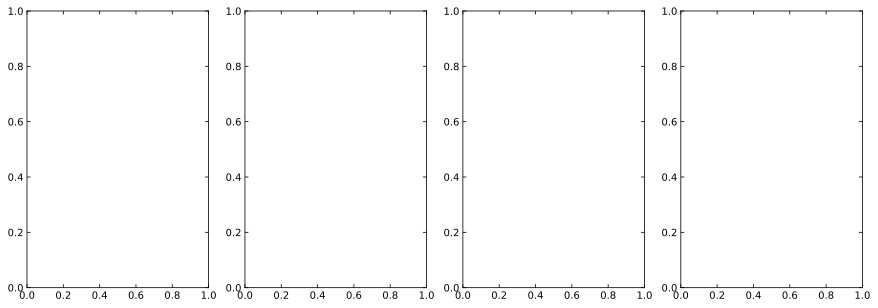

In [28]:
# Select graph indices to plot
graph_indices = [0, 8, 16, 24]

# Prepare subplots
fig, axes = plt.subplots(1, len(graph_indices), figsize=(15, 5))

for i, ax in enumerate(axes):
    # Get the graph
    graph = get_graph(graph_indices[i])

    # Make a copy of the graph to avoid modifying the original
    graph_copy = graph.clone()

    # Pass through the model up to the aggregation step
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        local_representations, _ = model(graph_copy.x, graph_copy.edge_index, graph_copy.batch)

    # Update graph node features with local representations for visualization
    graph_copy.x = local_representations

    # Plot the graph with updated local representations
    plot_graph(ax, graph_copy, s=1000)
    nice_plot_nodes(ax)

    # Add title
    ax.set_title(f"Graph {graph_indices[i]}")

# Adjust layout and show plot
plt.tight_layout()
plt.show()